# Mixture of unigrams model of text generation

This R Jupyter notebook explores the mixture of unigrams approach to text generation. Each document within the corpus is assumed to contain just a single topic.

Consider a set of topics $Z$. The probability that a document is generated from topic $z$ is denoted $p(z)$.

The distribution of tokens is dependent on the topic. The probability of token $t_i$ in topic $z$ is denoted $p(t_i | z)$.

The probability of the tokens $t$ in a document with $N$ tokens is given by

$$
p(t) = \sum_{z} \Big( p(z) \prod_{i=1}^{N} p(t_i | z) \Big)
$$

In [1]:
# Import the required libraries
library(DescTools)
library(MCMCpack)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=10, repr.plot.height=6)

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2021 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Data generation

In [2]:
# Number of topics
n_topics <- 3

# Number of distinct tokens
n_tokens <- 6

# Mean number of tokens in a document
lambda_tokens <- 20

# Probability that a document is about a topic
p_topic <- rdirichlet(1, rep(1, n_topics))

# Probability of a token given the topic
p_token_given_topic <- rdirichlet(n_topics, rep(0.1, n_tokens))

# Number of documents to generate
n_docs <- 10

In [3]:
# Convert a one-hot encoded value to a categorical value
one_hot_to_categorical <- function(x) {
    which(x == 1)[[1]]
}

In [4]:
# Topic contained in each document
topic <- rep(-1, n_docs)

# Number of tokens in the document
num_tokens_in_doc <- rep(0, n_docs)

# Token counts in each document
M <- matrix(0, nrow=n_docs, ncol=n_tokens)

# Walk through each document
for (d in 1:n_docs) {
    
    # Topic contained in document d
    topic[d] <- one_hot_to_categorical(rmultinom(1, 1, p_topic))
    
    # Number of tokens in document d
    num_tokens_in_doc[d] <- rpois(1, lambda_tokens)
    
    # Token counts for document d
    M[d,] <- rmultinom(1, num_tokens_in_doc[d], p_token_given_topic[topic[d],])
}

In [5]:
num_tokens_in_doc

[1] 17 18 24 23 23 15 19 23 20 25

In [6]:
M

1,0,16,0,0,0
1,0,17,0,0,0
0,0,0,24,0,0
1,0,22,0,0,0
1,0,0,22,0,0
0,0,0,15,0,0
0,0,0,19,0,0
1,0,22,0,0,0
1,0,1,18,0,0
4,0,21,0,0,0


In [7]:
topic

[1] 2 2 1 2 1 1 1 2 1 2

## Bayesian inference

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 15
   Total graph size: 61

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
lambda_tokens,20.59,1.42,17.93,20.55,23.44,NA,18814
p_topic[1],0.46,0.13,0.21,0.46,0.72,NA,20000
p_topic[2],0.08,0.07,0.00,0.06,0.27,NA,20000
p_topic[3],0.46,0.13,0.21,0.46,0.72,NA,20000
topic[1],1.00,0.01,1.00,1.00,1.00,NA,13242
topic[2],1.00,0.01,1.00,1.00,1.00,NA,20000
topic[3],3.00,0.00,3.00,3.00,3.00,NA,0
topic[4],1.00,0.01,1.00,1.00,1.00,NA,20000
topic[5],3.00,0.01,3.00,3.00,3.00,NA,20000


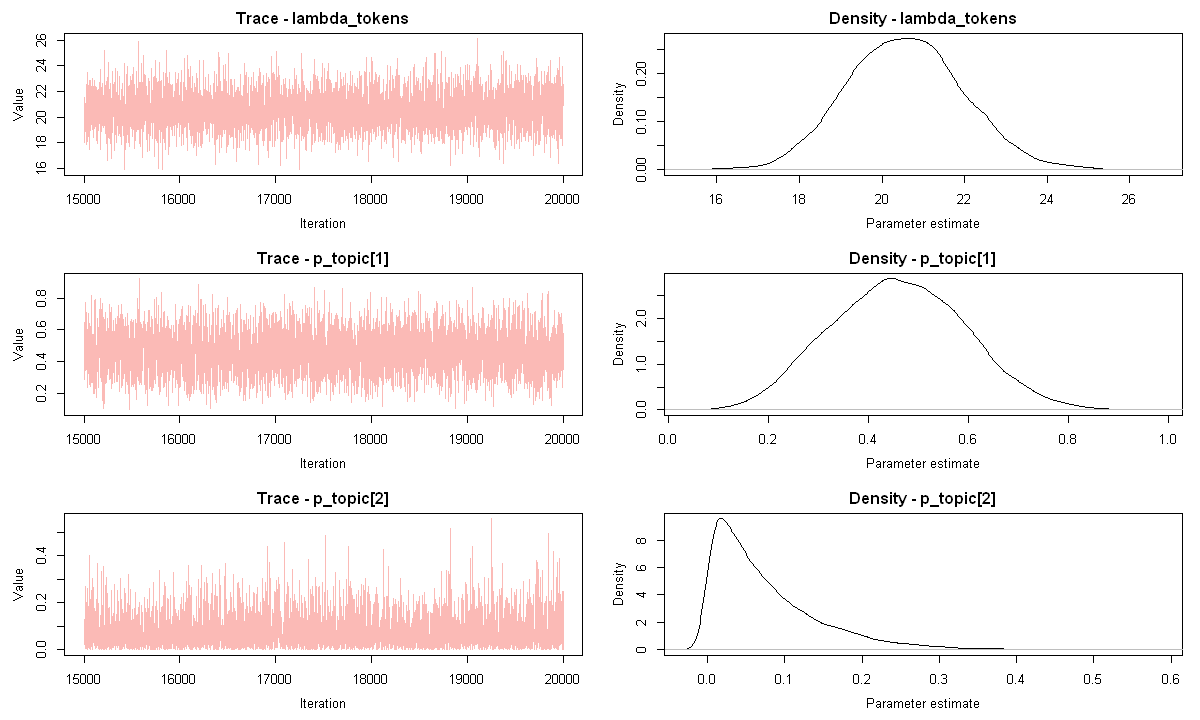

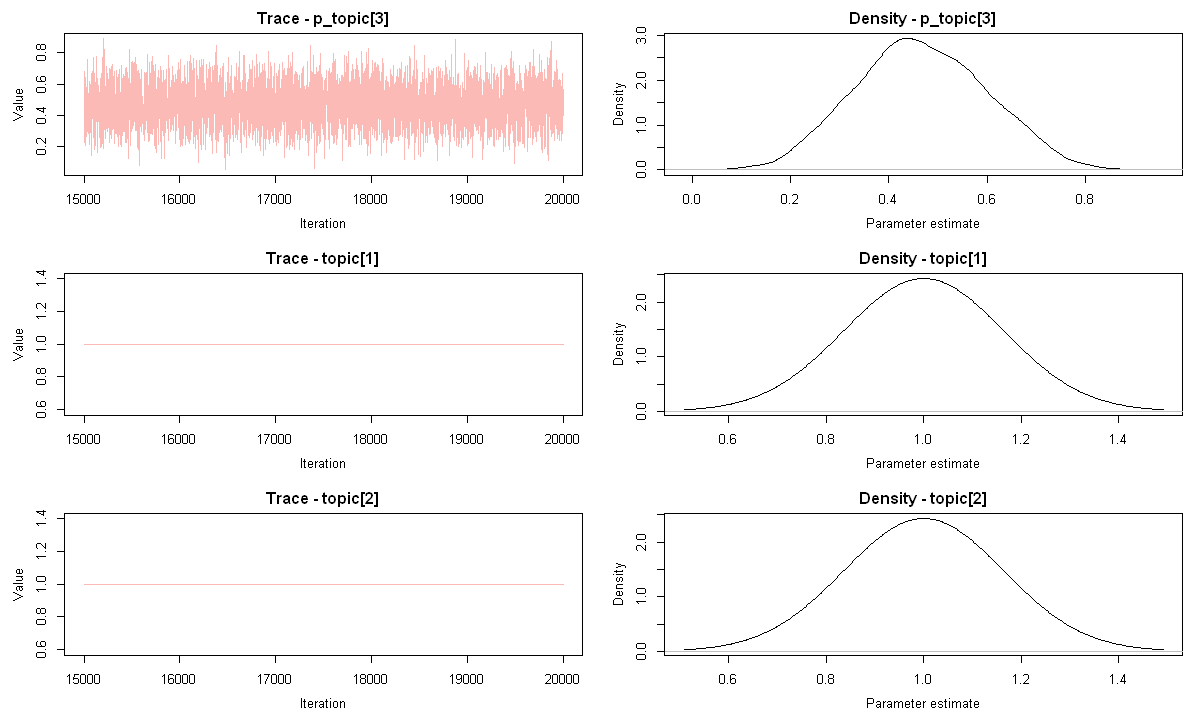

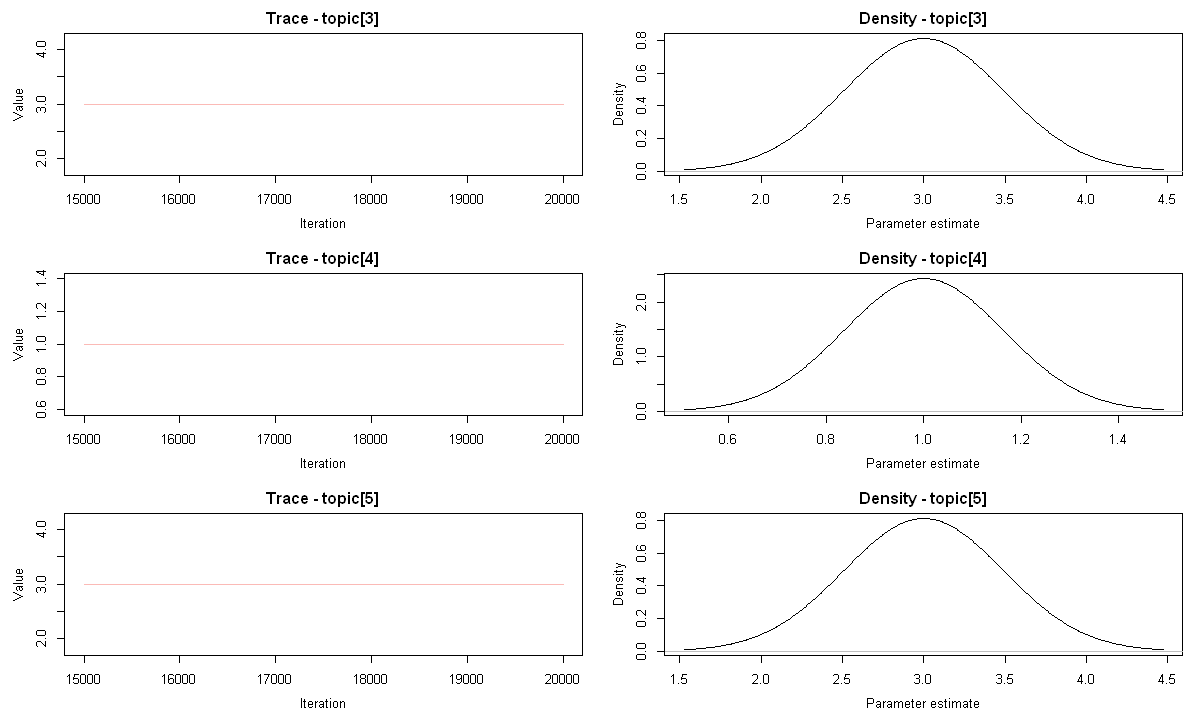

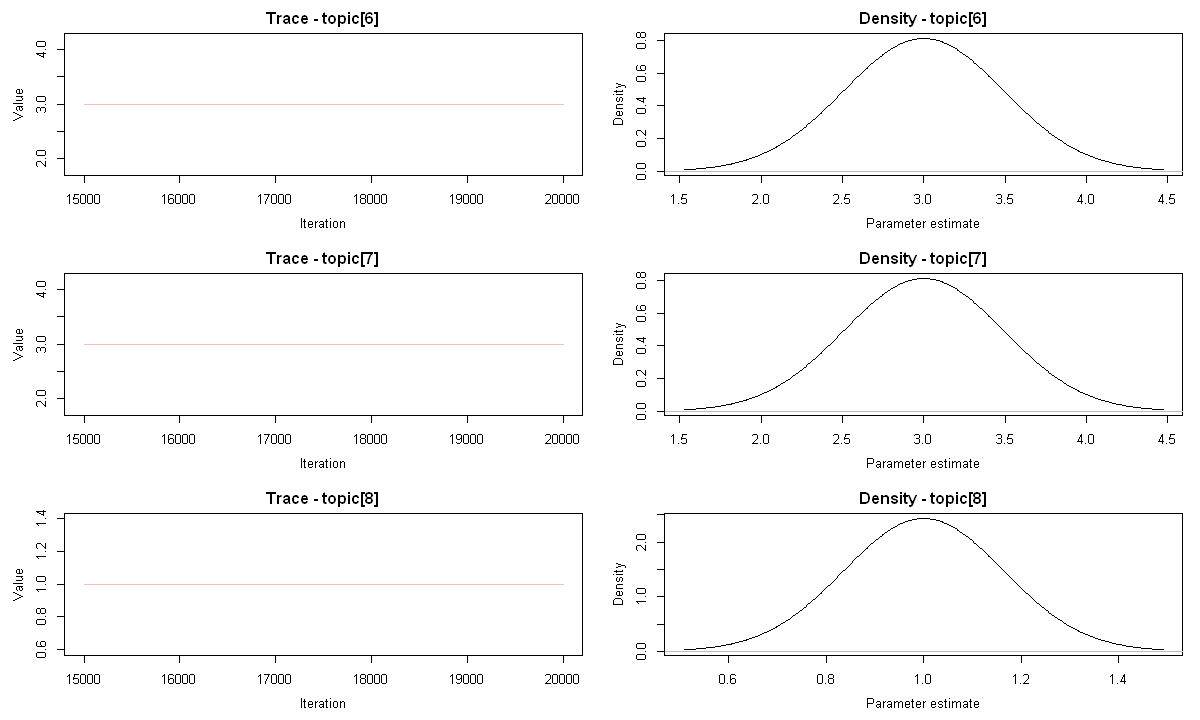

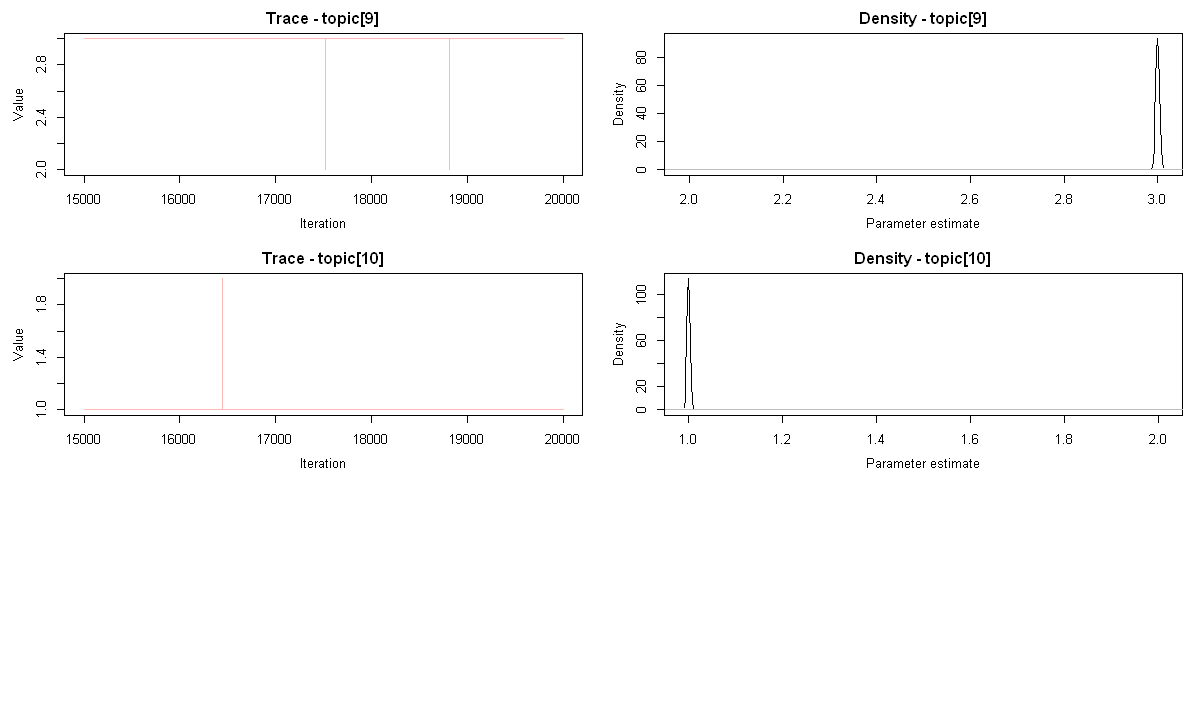

In [8]:
model_string = "
model {
    # Prior for the multinomial distribution of the token counts in a document
    for (j in 1:n_topics) {
        p_token_given_topic[j, 1:n_tokens] ~ ddirch(alpha_doc)
    }

    # Probability that a document is about a topic
    p_topic ~ ddirch(alpha_topic)

    # Mean number of tokens in a document
    lambda_tokens ~ dgamma(1, 0.1)

    # Likelihood
    for (d in 1:D) {
        
        # Topic contained in document (value ranges from 1 to number of topics)
        topic[d] ~ dcat(p_topic)

        # Number of tokens in the document
        num_tokens_in_doc[d] ~ dpois(lambda_tokens)

        # Token counts for document d
        M[d, 1:n_tokens] ~ dmulti(p_token_given_topic[topic[d], 1:n_tokens], num_tokens_in_doc[d])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(alpha_topic=rep(1,n_topics), 
                               alpha_doc=rep(1,n_tokens), 
                               n_topics=n_topics,
                               D=n_docs,
                               n_tokens=n_tokens, 
                               num_tokens_in_doc=num_tokens_in_doc,
                               M=M))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("lambda_tokens", "p_topic", "topic"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp,
          pdf=FALSE)

* If the token distribution of each document is similar, the inference really struggles to determine the topic contained in a document.

In [9]:
# Find the most frequent topic index for each document
most_frequent_topic <- rep(-1, n_docs)
for (i in 1:n_docs) {
    column_name <- paste0("topic[", i, "]")
    values <- as.matrix(samp)[,column_name]
    most_frequent_topic[i] <- Mode(values)
}

The topic indices won't be exactly the same except by chance, e.g. topic 1 in the generated data could map to topic 3 in the JAGS model.

In [10]:
most_frequent_topic

[1] 1 1 3 1 3 3 3 1 3 1

In [11]:
topic

[1] 2 2 1 2 1 1 1 2 1 2